In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

In [3]:
def plot_predictions(model, df, index, x, y):
    d = df
    test_series = pd.DataFrame({"ccs28": y})
    pred_series = model.predict(scaler.transform(x))
    pred_series = pd.DataFrame(
        {"ccs28-pred": pred_series.squeeze()}
    )

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color="r")  # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(
        ["train and test series", "end of train series", "predicted"], loc="upper left"
    )
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
    plt.show()

In [4]:
def create_keras_model(
    activation="swish", dropout_rate=0.0, n_units=0, n_layers=0, learning_rate=1e-3
):
    model = tf.keras.Sequential()

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(units=n_units, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

In [5]:
def get_baseline_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(units=32))
    model.add(tf.keras.layers.Dense(units=1))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

In [6]:
def make_repeated_kfold_cross_validation(x, y, params=None):
    if params is not None:
        activation = params["activation"]
        dropout_rate = params["dropout_rate"]
        n_units = params["n_units"]
        n_layers = params["n_layers"]
        learning_rate = params["learning_rate"]

    rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
    scores = []

    start = time.time()
    for train, test in rkf.split(x):
        if params is not None:
            model = create_keras_model(
                activation=activation,
                dropout_rate=dropout_rate,
                n_units=n_units,
                n_layers=n_layers,
                learning_rate=learning_rate,
            )
        else:
            model = get_baseline_model()
        model.fit(
            scaler.fit_transform(x[train]),
            y[train],
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
        )
        rmse = model.evaluate(scaler.transform(x[test]), y[test], verbose=0)
        scores.append(rmse[1])

    print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))
    end = time.time()
    print("Minutes Elapsed: ", (end - start) / 60)
    return rkf, scores

<h3>Disable Tensorflow Warnings</h3>

In [7]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Neural Network Feedforward - Multiple layers

<h3>Baseline model</h3>

<h4>Config:</h4>

1. Layers: 1

2. Units: 32

3. Learning rate: 1e-3

In [8]:
df = pd.read_csv("../../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv")

In [9]:
seed = 47
repeats = 10
n_splits = 10
epochs = 300
batch_size = 32
scaler = StandardScaler()

# Repeated KFold Cross validation

In [10]:
y = df.pop("28d compressive strength (MPa)").values
x = df.values

In [11]:
rkf1, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 5.165 (0.492)
Minutes Elapsed:  5.617935478687286


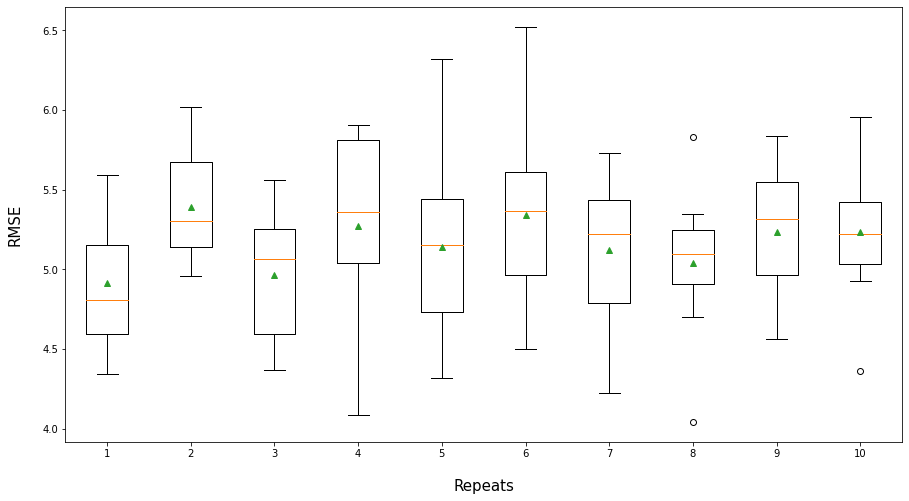

In [12]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=seed, shuffle=False
)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [14]:
model = get_baseline_model()
model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=0)
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 16.8802 - RMSE: 4.1086


[16.880207061767578, 4.108552932739258]

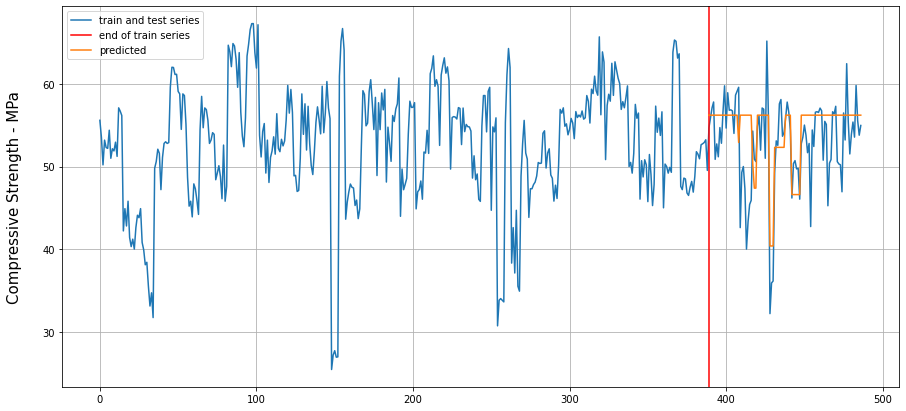

In [15]:
index = -98
plot_predictions(model, df, index, x, y)